In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import tensorflow as tf

# Set path to facades folder
base_path = '/content/drive/MyDrive/Internship_Prodigy/Datasets/facades'

trainA_path = os.path.join(base_path, 'train/trainA')
trainB_path = os.path.join(base_path, 'train/trainB')
testA_path = os.path.join(base_path, 'test/testA')
testB_path = os.path.join(base_path, 'test/testB')

IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_image(img_file):
    img = tf.io.read_file(img_file)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return img

def load_pair(img_path_A, img_path_B):
    input_image = load_image(img_path_A)
    target_image = load_image(img_path_B)
    return input_image, target_image

def get_dataset(path_A, path_B, max_images=None):
    files_A = sorted([os.path.join(path_A, fname) for fname in os.listdir(path_A)])
    files_B = sorted([os.path.join(path_B, fname) for fname in os.listdir(path_B)])

    if max_images:
        files_A = files_A[:max_images]
        files_B = files_B[:max_images]

    dataset = tf.data.Dataset.from_tensor_slices((files_A, files_B))
    dataset = dataset.map(load_pair, num_parallel_calls=AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(500)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


In [4]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-5wj7a6y4
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-5wj7a6y4
  Resolved https://github.com/tensorflow/examples.git to commit 3c7435733a9162481df350e57c53e58d2a705e4d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1746868094.345130988853936603129253091149118257392589495885-py3-none-any.whl size=301646 sha256=7540d9a78835f5d0491318863928756ee3de10318923235afcce640a40a46067
  Stored in directory: /tmp/pip-ephem-wheel-cache-2l6ez7a8/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [5]:
from tensorflow_examples.models.pix2pix import pix2pix

generator = pix2pix.unet_generator(3, norm_type='instancenorm')
discriminator = pix2pix.discriminator(norm_type='instancenorm', target=True)


In [6]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (100 * l1_loss)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [7]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [9]:
# Assuming trainA_path, trainB_path, testA_path, and testB_path are defined from previous cells

EPOCHS = 50

# Create the training and testing datasets
train_dataset = get_dataset(trainA_path, trainB_path)
test_dataset = get_dataset(testA_path, testB_path)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for input_image, target in train_dataset:
        train_step(input_image, target)


Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


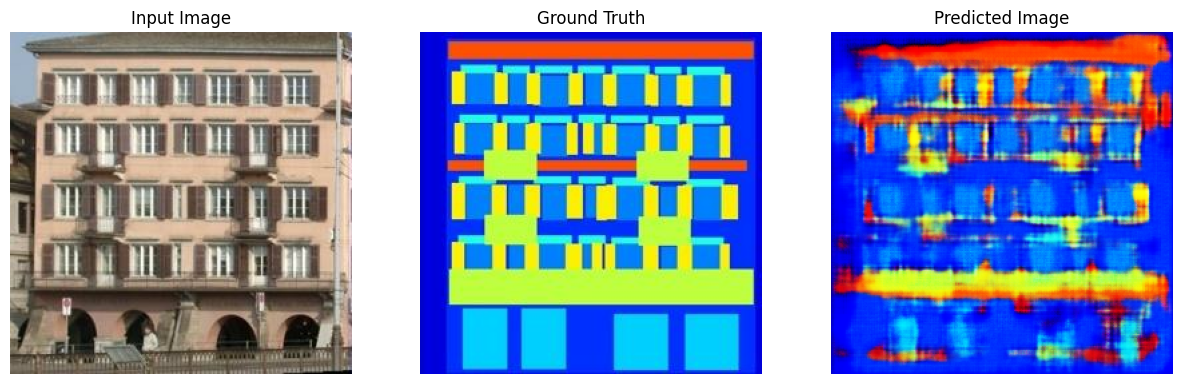

In [11]:
import matplotlib.pyplot as plt

def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 5))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.show()

for inp, tar in test_dataset.take(1):
    generate_images(generator, inp, tar)
